# Memory Aware Synapses
[Paper](https://arxiv.org/abs/1711.09601)
[Code](https://github.com/rahafaljundi/MAS-Memory-Aware-Synapses)
[Code-PyTorch](https://github.com/wannabeOG/MAS-PyTorch)

## Main Contributions:

* Proposes a regularization-based method (parameters are regularized based on their importance) that uses the sensititivity of the network's output function to the change in parameters as a measure of parameter importance.
* Parameter importance can be computed in an unsupervised manner without the need of labels (parameter importance is not dependent on the loss)
* Specific groups or tasks can be prioritized for not forgetting. This way parameters can be freed up from remembering unimportant things.
* Link with Hebbian Learning
* Global MAS - uses $L_2^2$ norm of output, Local MAS - uses layer wise outputs for gradient computation.
* Better performance than SI, EWC, LwF, ELLB, IMM.
* Among the competing methods, SI and EWC perform the best.
* Can be used with a pretrained model (importance calculation can be independent from initial training phase)
* Points out short-comings of SI (check related work for hand-written comments on disadvantages of SI and advantages of MAS over SI)

## How is parameter importance calculated?

A trained model learns an approximation $F$ of the true function $\bar{F}$. 

Need to measure how sensitive the function $F$ is to changes in the network parameters. For a given datapoint $x_k$, the output is $F(x_k, \theta)$.

A small perturbation $\delta=\{\delta_{ij}\}$ in the parameters $\theta=\{\theta_{ij}\}$ results in a change in $F$, that can be approximated by:
\begin{equation}
 F(x_k; \theta+\delta) -F(x_k; \theta) \approx \sum_{i,j} \cfrac{\partial{(F(x_k;\theta))}}{\partial \theta_{ij}}\delta_{ij} = \sum_{i,j} g_{ij}(x_k)\delta_{ij}
\end{equation}

The importance of a parameter $\theta_{ij}$ is measured by the magnitude of the gradient $g_{ij}$. The importance is summed over all datapoints to get the final importance measure.

\begin{equation}
    \Omega_{ij} = \cfrac{1}{N} \sum_{k=1}^{N} \vert\vert g_{ij}(x_k) \vert\vert
\end{equation}

In most cases, $F$ is multi-dimensional. Thus multiple backward passes need to be performed to compute the gradient w.r.t. each dimension of $F$. To avoid this, the squared-$L_2$ norm of $F$ is used to compute the gradient. In this way only 1 backward pass is necessary. Thus $g_{ij}(x_k) = \cfrac{\partial{[L_2^2(F(x_k;\theta))]}}{\partial \theta_{ij}}$. It is verified empirically in the paper that using the $L_2$ norm has the same performance.

The loss function for learning the $n^{\text{th}}$ task is given by

\begin{equation}
    \mathcal{L}(\theta) = \mathcal{L_n}(\theta) + \lambda \sum_{i,j} \Omega_{ij}(\theta_{ij} - \theta^*_{ij})^2
\end{equation}

where $\lambda$ is the regularization strength, $\theta^*_{ij}$ is the parameters learned till task $n-1$ and $\mathcal{L_n}(\theta)$ is the task specific loss for task $n$    . The importance term $\Omega$ is accumulated (summed, or averaged?) with the previous $\Omega$.

## Specifics
* 3 kinds of evaluations:
    - 2 task sequences using 3 different **image classification** datasets, comparing 6 methods
    - Longer sequence of 8 tasks using 8 different classification datasets, comparing 7 methods
    - 4 task sequence using different groups of a **fact-learning** dataset (6DS), comparing 4 methods (including joint training and finetuning)
* Network types:
    - For image classification experiments: AlexNet (PyTorch model has 61.1 million parameters). Multi-headed architecture is used (one head per task).
    - For fact learning task, a VGG-16 network (PyTorch model has 138.4 million parameters) is used in which all parameters are shared (not multi-headed for tasks). The network has 3 heads corresponding to the 3 outputs that are needed for all tasks.
* Global MAS is used for experiments.
* Importance weights are estimated using training data.
* $\lambda=1$ is used.


In [1]:
import numpy as np
import random
from sklearn.metrics import accuracy_score
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn import Sequential
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from continuum import Rotations, Permutations
from continuum.datasets import MNIST

import time

In [2]:
def check_cuda():
    """
    Checks if GPU is available.
    """    
    cuda_available = torch.cuda.is_available()
    device = torch.device('cuda' if cuda_available else 'cpu')
    return cuda_available, device

def set_seed(seed=1000):
    """
    Sets the seed for reproducability
    """
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    cuda_available, _ = check_cuda()
    if cuda_available:
        torch.backends.cudnn.benchmark = False
        torch.use_deterministic_algorithms(True)
        torch.backends.cudnn.deterministic = True
        torch.cuda.manual_seed_all(seed)

In [3]:
def get_cl_metrics(arr):
    """
    Given an array of validation accuracies (each current task along the rows,
    and accuracy of the tasks in the columns), this function computes the 
    CL metrics according to the following paper:
    Don't forget, there is more than forgetting: new metrics for Continual Learning,
    Natalia Díaz-Rodríguez et al. [https://arxiv.org/pdf/1810.13166.pdf]
    
    We are using our own function instead of the Logger from continvvm because of
    a lack of sufficient documentation, and to illustrate how the CL metrics can 
    be computed.
    
    The following metrics are computed:
        - Accuracy,
        - Backward Transfer,
        - BWT+,
        - REM,
        - FWT
        
    Args:
        arr (Numpy array): Array of validation accuracies

    Returns:
        cl_metrics (dict): Dictionary of CL metrics acc, bwt, bwt_plus, rem, fwt
    """

    n = arr.shape[0]

    # Accuracy considers the average accuracy by considering the diagonal 
    # elements as well as all elements below it
    # This is equivalent to computing the sum of the lower traingular matrix
    # and dividing that sum by N(N+1)/2
    acc = np.sum(np.tril(arr))/(n*(n+1)/2.0)

    # Backward transfer (BWT) 
    bwt = 0.0
    for i in range(1, n):
        for j in range(0, i):
            bwt += (arr[i,j] - arr[j,j])
    bwt /= (n*(n-1)/2.0)   

    rem = 1.0 - np.abs(np.min([bwt, 0.0]))
    bwt_plus = np.max([bwt, 0.0])

    # Forward Transfer:  FWT measures the influence that learning a task has 
    # on the performance of future tasks
    # This is the average accuracy for the train-test accuracy entries
    # above the principal diagonal, excluding it 
    # This is equivalent to the sum of the upper tril minus the trace
    fwt = (np.sum(np.triu(arr)) - np.trace(arr))/(n*(n-1)/2.0)

    cl_metrics = {'acc': acc, 'bwt': bwt, 'bwt_plus': bwt_plus, 'rem': rem, 'fwt': fwt}
    return cl_metrics

In [4]:
def get_avg_acc(arr):
    """
    Computes the average accuracies over validation tasks
    
    Args:
        arr (Numpy array): Array of validation accuracies (each current task 
                           along the rows,and accuracy of the tasks in the columns)
                           
    Returns:
        avg_acc_curr_past (Numpy array):
        avg_acc_all (Numpy array):
    """
    
    (nb_tasks, _) = arr.shape
    
    avg_acc_curr_past = np.zeros((nb_tasks,))
    avg_acc_all = np.zeros((nb_tasks,))
    
    for curr_task in range(nb_tasks):
        avg_acc_curr_past[curr_task] = np.mean(arr[curr_task,:curr_task+1])
        avg_acc_all[curr_task] = np.mean(arr[curr_task,:])
        
    return avg_acc_curr_past, avg_acc_all

In [5]:
class MemoryAwareSynapsesLearner(nn.Module):
    
    def __init__(self, mas_lambda, lr, model=None):
        """
        Initialize the MemoryAwareSynapsesLearner object.
        Creates the network, sets the MAS hyperparameters and
        initializes the buffer objects required for updates.
        
        Args:
            mas_lambda (float): Regularization strength parameters
            lr (float): Learning rate for optimizer
            model (torch.nn.module): The network model

        """
        super().__init__()
        
        # Set the network
        if model is not None:
            self.model = model
        else:
            self.model = Sequential(nn.Linear(784, 2000),
                         nn.ReLU(),
                         nn.Linear(2000,2000),
                         nn.ReLU(),
                         nn.Linear(2000,10))
        
        # Set the MAS hyperparameters
        self.mas_lambda = mas_lambda           
        
        # Optimizer hyperparameters
        self.lr = lr
        
        # Setting buffers for regularization parameters
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                n = n.replace('.', '__')
                self.register_buffer(f'{n}_theta_prev', p.data.detach().clone().zero_())
                self.register_buffer(f'{n}_omega_curr', p.data.detach().clone().zero_())
                self.register_buffer(f'{n}_omega_prev', p.data.detach().clone().zero_())
                        
        # Set the optimizer
        self.reset_optimizer()
                
    def reset_optimizer(self):
        """
        Resets the optimizer
        """
        self.optimizer = optim.Adam(self.model.parameters(), self.lr)     
        
    def update_omega(self, dataloader, device='cpu', timeit=False):
        """
        Updates the per-parameter importance once training is complete for a task.
        
        Here, we compute the per-sample gradient by iterating over a dataloader
        with a bach size of 1, but this is painfully slow. 
        More efficient implements are possible. For example, 
        see: [BackPACK](https://github.com/f-dangel/backpack). However,
        further tests are needed for more complex architectures.
        """
        start = time.time()
        
        # Find the number of data points
        datalen = len(dataloader.dataset)

        # Find the number of batches
        num_batches = len(dataloader)
        
        # We need per sample gradients
        # Make sure that the batch size is 1
        # that is the number of batches should equal the number of data points
        assert num_batches == datalen, 'Batch-size must be 1 for per-sample gradients'
        
        # Set the model to eval
        self.model = self.model.to(device)
        self.model.eval()
                
        for x, _, _ in tqdm(dataloader):
            
            # Need to convert to cuda
            # How does this work in PL?
            x = x.to(device)
            
            # Reset all gradients of the model
            self.model.zero_grad()
            
            # Forward pass to compute the output
            x = torch.flatten(x, 1)
            output = self.model(x)
            
            # L2 norm of the output
            l2_norm = torch.norm(output, p=2, dim=1)
            
            # Square the L2 norm and sum
            sum_sq_l2_norm = torch.sum(l2_norm**2)
            
            # Compute the gradients (backward pass)
            sum_sq_l2_norm.backward()
            
            # Loop over all parameters
            for n, p in self.model.named_parameters():
                if p.requires_grad:
                    n = n.replace('.', '__')
                    
                    # Retrieve current omega for this parameter
                    try:
                        omega_curr = getattr(self, f'{n}_omega_curr')
                    except AttributeError:
                        omega_curr = p.detach().clone().zero_()
                    
                    # Retrieve the absolute current gradient for this parameter
                    p_abs_grad = torch.abs(p.grad.detach().clone())
                                        
                    # Update the current omega for this parameter
                    # The gradient is normalized by the number of datapoints
                    omega_curr = torch.add(omega_curr, p_abs_grad, alpha=1.0/datalen)
                    
                    # Update the current omega in the buffer
                    self.register_buffer(f'{n}_omega_curr', omega_curr)
                    
        end = time.time()
        if timeit:
            print(f'Total time for omega update: {end-start}')
                    
    def merge_omega(self):     
        """
        Once omega for the current task has been computed, merge this 
        with the omega computed for the previous tasks
        """ 
        
        # Loop over all parameters
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                n = n.replace('.', '__')

                # Retrieve previous omega for this parameter
                try:
                    omega_prev = getattr(self, f'{n}_omega_prev')
                except AttributeError:
                    omega_prev = p.detach().clone().zero_()

                # Retrieve current omega for this parameter
                omega_curr = getattr(self, f'{n}_omega_curr')

                # Update the current omega
                omega_curr = torch.add(omega_prev, omega_curr)
                self.register_buffer(f'{n}_omega_prev', omega_curr)
                
    def update_theta_prev(self):
        """
        Once training is over for the current task, the current
        parameter values need to be saved
        """
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                n = n.replace('.', '__')
                self.register_buffer(f'{n}_theta_prev', p.data.detach().clone())

    def regularization_loss(self):
        """
        Computes the regularization loss in MAS using the per-parameter importance and
        the current and previous parameter values.
        """
        try:
            losses = []
            for n, p in self.model.named_parameters():
                if p.requires_grad:
                    # Retrieve previous parameter values and the corresponding omega
                    n = n.replace('.', '__')
                    prev_values = getattr(self, f'{n}_theta_prev')
                    omega_prev = getattr(self, f'{n}_omega_prev')
                    # Calculate MAS's surrogate loss, sum over all parameters
                    losses.append((omega_prev * (p-prev_values)**2).sum())
            return sum(losses)
        except AttributeError:
            # Regularization loss is 0 if there is no stored omega yet
            return torch.tensor(0.)
        
    def train_step(self, x, y, t):
        """
        Single batch of training
        
        Args:
            x (torch tensor): Batch of inputs
            y (torch tensor): Batch of labels
            t (torch tensor): Batch of task ids
        """
        
        # Zero the parameter gradients
        self.optimizer.zero_grad()

        # Perform a forward pass and compute the cross entropy loss
        x = torch.flatten(x, 1)
        y_hat = self.model(x)
        loss = F.cross_entropy(input=y_hat, target=y, reduction='mean')
        
        # Compute the MAS regularization loss
        regularization_loss = self.regularization_loss()
        loss += self.mas_lambda * regularization_loss
        
        # Backprop and gradient step
        loss.backward()
        self.optimizer.step()

        # Compute the training accuracy
        pred = torch.argmax(y_hat, dim=-1)
        acc = accuracy_score(y.detach().cpu().numpy(), pred.detach().cpu().numpy(), normalize=True)
                
        # Return the training accuracy
        return acc
            
    def val_step(self, x, y, t):
        """
        Single batch of validation
        
        Args:
            x (torch tensor): Batch of inputs
            y (torch tensor): Batch of labels
            t (torch tensor): Batch of task ids
        """
                
        with torch.no_grad():
            
            # Forward pass
            x = torch.flatten(x, 1)
            y_hat = self.model(x)
            
            # Compute the validation accuracy
            pred = torch.argmax(y_hat, dim=-1)
            acc = accuracy_score(y.detach().cpu().numpy(), pred.detach().cpu().numpy(), normalize=True)
            
        return acc

In [18]:
def train_val(model, 
              list_degrees, 
              train_dataset, 
              val_dataset, 
              num_epochs, 
              batch_size, 
              seeds,
              mnist_type='Rotated',
              num_tasks=None,
              reg=True, 
              device='cpu'):
    """
    Complete training and validation loop over all tasks.
    
    Once training is complete for a task, validation is performed using the validation
    datasets of all past, current and future tasks. This is needed for computing the 
    CL metrics.
    
    Args:
        model (MemoryAwareSynapsesLearner): The learner class
        list_degrees (list): List of angles in degrees for the RotatedMNIST tasks
        train_dataset (MNIST): Training MNIST Dataset object 
        val_dataset (MNIST): Validation MNIST Dataset object 
        num_epochs (int): Number of training epochs
        seeds (int): List of seeds for PMNIST
        mnist_type (str): Rotated or Permuted
        batch_size (int): Batch size for training
        device (str): Device to use for training ('cpu' or 'cuda')
        
    Returns:
        val_acc_arr (Numpy array): Array of validation accuracies (each current task 
                                   along the rows,and accuracy of the tasks in the columns)
    """
    nb_tasks = len(list_degrees) if num_tasks is None else num_tasks

    # Array to store validation accuracies (each current task along the rows,
    # and accuracy of the tasks in the columns)
    val_acc_arr = np.zeros((nb_tasks, nb_tasks))

    if mnist_type == 'Rotated':
        train_scenario = Rotations(cl_dataset=train_dataset,
                                   nb_tasks=nb_tasks,
                                   list_degrees=list_degrees)

        val_scenario = Rotations(cl_dataset=val_dataset,
                                 nb_tasks=nb_tasks,
                                 list_degrees=list_degrees)
        
    elif mnist_type == 'Permuted':
        train_scenario = Permutations(cl_dataset=train_dataset,
                                      nb_tasks=nb_tasks,
                                      seed=seeds,
                                      shared_label_space=True)
        
        val_scenario = Permutations(cl_dataset=val_dataset,
                                    nb_tasks=nb_tasks,
                                    seed=seeds,
                                    shared_label_space=True)


    for task_id, train_taskset in enumerate(train_scenario):

        print(f'Starting task_id: {task_id}')

        train_loader = DataLoader(train_taskset, batch_size=batch_size, shuffle=True)

        for epoch in range(num_epochs):
            
            print(f'Starting epoch: {epoch}')
            
            model.train()

            train_accuracies = list()

            for x, y, t in tqdm(train_loader):
                train_accuracies.append(model.train_step(x.to(device), y.to(device), t.to(device)))

            train_acc = np.mean(train_accuracies)

            print(f'task_id: {task_id}, epoch: {epoch}, train_accuracy: {train_acc}')

        if reg:
            # Update omega on ending a task
            # We need to pass a dataloader with a batch size of 1
            data_loader_omega = DataLoader(val_scenario[task_id], batch_size=1, shuffle=False)
            model.update_omega(data_loader_omega, device=device)

            # Save the parameters
            model.update_theta_prev()

            # Merge with previous omega if there were previous tasks
            if task_id > 0:
                model.merge_omega()

        # At the end of the epoch validate on all tasks (past, current, and future tasks)
        model.eval()
        for val_task_id, val_taskset in enumerate(val_scenario):
            val_loader = DataLoader(val_taskset, batch_size=1, shuffle=False)
            val_accuracies = list()

            for x, y, t in val_loader:
                val_accuracies.append(model.val_step(x.to(device), y.to(device), t.to(device)))

            val_acc = np.mean(val_accuracies)

            val_acc_arr[task_id][val_task_id] = val_acc

            print(f'Current task: {task_id}, Validating on task: {val_task_id}, Accuracy: {val_acc}')
            
        
            
    return val_acc_arr

## Rotated MNIST (5 tasks)

In [7]:
# Setting hyperparameters
NUM_EPOCHS = 1  # instead of 20 (in the paper)
MAS_LAMBDA = 1.0
LEARNING_RATE = 0.001
BATCH_SIZE = 256

In [8]:
# Check if CUDA is available
cuda_available, device = check_cuda()
print(f'cuda_available: {cuda_available}, device: {device}')

cuda_available: False, device: cpu


In [9]:
# Create the Dataset objects
list_degrees = [0, 45, 90, 135, 180]
train_dataset = MNIST(data_path="dataset", download=True, train=True)
val_dataset = MNIST(data_path="dataset", download=True, train=False)

In [10]:
set_seed()

# Create the learner object
mas_model = MemoryAwareSynapsesLearner(mas_lambda=MAS_LAMBDA, lr=LEARNING_RATE)
mas_model = mas_model.to(device)

In [11]:
# Train using MAS
val_acc_arr = train_val(model=mas_model, 
                        list_degrees=list_degrees, 
                        train_dataset=train_dataset, 
                        val_dataset=val_dataset,
                        num_epochs=NUM_EPOCHS, 
                        batch_size=BATCH_SIZE)

Starting task_id: 0
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 0, epoch: 0, train_accuracy: 0.9314937943262412


  0%|          | 0/10000 [00:00<?, ?it/s]

Current task: 0, Validating on task: 0, Accuracy: 0.9729
Current task: 0, Validating on task: 1, Accuracy: 0.3472
Current task: 0, Validating on task: 2, Accuracy: 0.1639
Current task: 0, Validating on task: 3, Accuracy: 0.1865
Current task: 0, Validating on task: 4, Accuracy: 0.2796
Starting task_id: 1
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 1, epoch: 0, train_accuracy: 0.9427526595744681


  0%|          | 0/10000 [00:00<?, ?it/s]

Current task: 1, Validating on task: 0, Accuracy: 0.709
Current task: 1, Validating on task: 1, Accuracy: 0.9735
Current task: 1, Validating on task: 2, Accuracy: 0.3916
Current task: 1, Validating on task: 3, Accuracy: 0.142
Current task: 1, Validating on task: 4, Accuracy: 0.2616
Starting task_id: 2
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 2, epoch: 0, train_accuracy: 0.9028257978723404


  0%|          | 0/10000 [00:00<?, ?it/s]

Current task: 2, Validating on task: 0, Accuracy: 0.3755
Current task: 2, Validating on task: 1, Accuracy: 0.8003
Current task: 2, Validating on task: 2, Accuracy: 0.9523
Current task: 2, Validating on task: 3, Accuracy: 0.3657
Current task: 2, Validating on task: 4, Accuracy: 0.1527
Starting task_id: 3
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 3, epoch: 0, train_accuracy: 0.85823359929078


  0%|          | 0/10000 [00:00<?, ?it/s]

Current task: 3, Validating on task: 0, Accuracy: 0.3839
Current task: 3, Validating on task: 1, Accuracy: 0.682
Current task: 3, Validating on task: 2, Accuracy: 0.8351
Current task: 3, Validating on task: 3, Accuracy: 0.9215
Current task: 3, Validating on task: 4, Accuracy: 0.3584
Starting task_id: 4
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 4, epoch: 0, train_accuracy: 0.8510693705673759


  0%|          | 0/10000 [00:00<?, ?it/s]

Current task: 4, Validating on task: 0, Accuracy: 0.3166
Current task: 4, Validating on task: 1, Accuracy: 0.4687
Current task: 4, Validating on task: 2, Accuracy: 0.4883
Current task: 4, Validating on task: 3, Accuracy: 0.7157
Current task: 4, Validating on task: 4, Accuracy: 0.9292


In [12]:
# Compute the CL metrics
cl_metrics = get_cl_metrics(val_acc_arr)

# Compute the average accuracy (over other tasks) for each current task
avg_acc_curr_past, avg_acc_all = get_avg_acc(val_acc_arr)

In [13]:
set_seed()

# Train another model without any continual learning
mas_model_no_cl = MemoryAwareSynapsesLearner(mas_lambda=0.0, lr=LEARNING_RATE)
mas_model_no_cl = mas_model_no_cl.to(device)
val_acc_arr_no_cl = train_val(model=mas_model_no_cl, 
                              list_degrees=list_degrees, 
                              train_dataset=train_dataset, 
                              val_dataset=val_dataset,
                              num_epochs=NUM_EPOCHS, 
                              batch_size=BATCH_SIZE,
                              reg=False,
                              device=device)

Starting task_id: 0
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 0, epoch: 0, train_accuracy: 0.9314937943262412
Current task: 0, Validating on task: 0, Accuracy: 0.9729
Current task: 0, Validating on task: 1, Accuracy: 0.3472
Current task: 0, Validating on task: 2, Accuracy: 0.1639
Current task: 0, Validating on task: 3, Accuracy: 0.1865
Current task: 0, Validating on task: 4, Accuracy: 0.2796
Starting task_id: 1
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 1, epoch: 0, train_accuracy: 0.94182734929078
Current task: 1, Validating on task: 0, Accuracy: 0.685
Current task: 1, Validating on task: 1, Accuracy: 0.9653
Current task: 1, Validating on task: 2, Accuracy: 0.3718
Current task: 1, Validating on task: 3, Accuracy: 0.1271
Current task: 1, Validating on task: 4, Accuracy: 0.2511
Starting task_id: 2
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 2, epoch: 0, train_accuracy: 0.9448581560283689
Current task: 2, Validating on task: 0, Accuracy: 0.2556
Current task: 2, Validating on task: 1, Accuracy: 0.6963
Current task: 2, Validating on task: 2, Accuracy: 0.9718
Current task: 2, Validating on task: 3, Accuracy: 0.4062
Current task: 2, Validating on task: 4, Accuracy: 0.1608
Starting task_id: 3
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 3, epoch: 0, train_accuracy: 0.9452681737588652
Current task: 3, Validating on task: 0, Accuracy: 0.2435
Current task: 3, Validating on task: 1, Accuracy: 0.2795
Current task: 3, Validating on task: 2, Accuracy: 0.7516
Current task: 3, Validating on task: 3, Accuracy: 0.9744
Current task: 3, Validating on task: 4, Accuracy: 0.4547
Starting task_id: 4
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 4, epoch: 0, train_accuracy: 0.9514738475177306
Current task: 4, Validating on task: 0, Accuracy: 0.29
Current task: 4, Validating on task: 1, Accuracy: 0.2847
Current task: 4, Validating on task: 2, Accuracy: 0.3746
Current task: 4, Validating on task: 3, Accuracy: 0.7678
Current task: 4, Validating on task: 4, Accuracy: 0.9728


In [14]:
# Compute the CL metrics
cl_metrics_no_cl = get_cl_metrics(val_acc_arr_no_cl)

# Compute the average accuracy (over other tasks) for each current task
avg_acc_curr_past_no_cl, avg_acc_all_no_cl = get_avg_acc(val_acc_arr_no_cl)

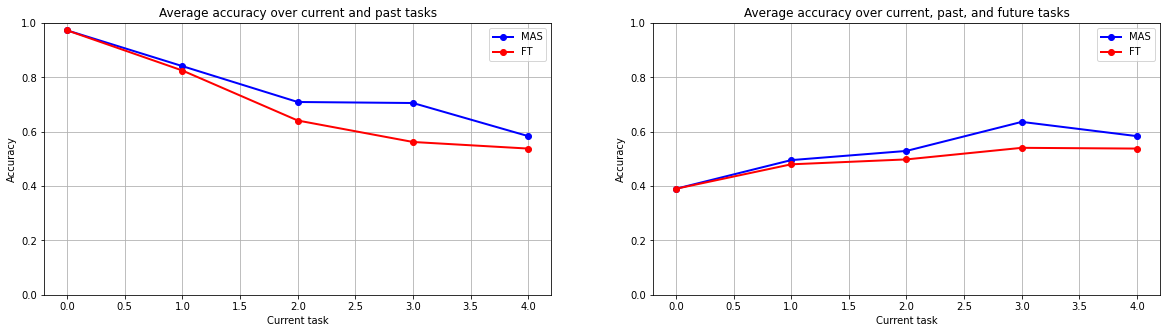

In [15]:
# Compare the results

# Line plots for average accuracy

fig, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].plot(avg_acc_curr_past, lw=2, color='blue', marker='o', label='MAS')
ax[0].plot(avg_acc_curr_past_no_cl, lw=2, color='red', marker='o', label='FT')

ax[1].plot(avg_acc_all, lw=2, color='blue', marker='o', label='MAS')
ax[1].plot(avg_acc_all_no_cl, lw=2, color='red', marker='o', label='FT')

ax[0].set_title("Average accuracy over current and past tasks")
ax[1].set_title("Average accuracy over current, past, and future tasks")
for a in ax:
    a.set_xlabel("Current task")
    a.set_ylabel("Accuracy")
    a.set_ylim([0.0,1.0])
    a.grid(True)
    a.legend()

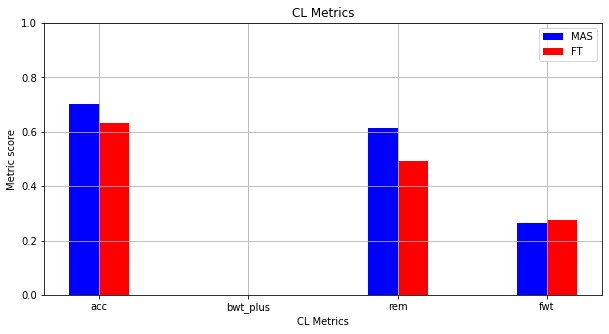

In [16]:
# Bar plots for CL metrics

fig, ax = plt.subplots(1,1,figsize=(10,5))
width = 0.2

ax.bar(np.arange(4)-width/2.0, 
      (cl_metrics['acc'], cl_metrics['bwt_plus'], cl_metrics['rem'], cl_metrics['fwt']), 
       width=width, 
       label='MAS',
       color='blue')
ax.bar(np.arange(4)+width/2.0, 
      (cl_metrics_no_cl['acc'], cl_metrics_no_cl['bwt_plus'], cl_metrics_no_cl['rem'], cl_metrics_no_cl['fwt']), 
       width=width, 
       label='FT',
       color='red')

ax.grid(True)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['acc', 'bwt_plus', 'rem', 'fwt'])
ax.set_xlabel('CL Metrics')
ax.set_ylabel('Metric score')
ax.set_ylim([0.0, 1.0])
ax.legend()
_ = ax.set_title('CL Metrics')

## Permuted MNIST (5 tasks)

In [20]:
# Setting hyperparameters
SEED = 1000
NUM_EPOCHS = 5  
MAS_LAMBDA = 1.0
LEARNING_RATE = 0.001
BATCH_SIZE = 256
SEEDS = [100, 200, 300, 400]

set_seed(SEED)

# Check if CUDA is available
cuda_available, device = check_cuda()
print(f'cuda_available: {cuda_available}, device: {device}')

train_dataset = MNIST(data_path="dataset", download=True, train=True)
val_dataset = MNIST(data_path="dataset", download=True, train=False)

# Create the learner object
mas_model = MemoryAwareSynapsesLearner(mas_lambda=MAS_LAMBDA, lr=LEARNING_RATE)
mas_model = mas_model.to(device)

# Train using MAS
val_acc_arr = train_val(model=mas_model, 
                        list_degrees=None, 
                        train_dataset=train_dataset, 
                        val_dataset=val_dataset,
                        num_epochs=NUM_EPOCHS, 
                        batch_size=BATCH_SIZE,
                        seeds=SEEDS,
                        mnist_type='Permuted',
                        num_tasks=5)
                        
# Compute the CL metrics
cl_metrics = get_cl_metrics(val_acc_arr)

# Compute the average accuracy (over other tasks) for each current task
avg_acc_curr_past, avg_acc_all = get_avg_acc(val_acc_arr)

cuda_available: False, device: cpu
Starting task_id: 0
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 0, epoch: 0, train_accuracy: 0.9314937943262412
Starting epoch: 1


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 0, epoch: 1, train_accuracy: 0.9759363918439715
Starting epoch: 2


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 0, epoch: 2, train_accuracy: 0.9847129875886524
Starting epoch: 3


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 0, epoch: 3, train_accuracy: 0.9895777925531914
Starting epoch: 4


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 0, epoch: 4, train_accuracy: 0.9906471631205673


  0%|          | 0/10000 [00:00<?, ?it/s]

Current task: 0, Validating on task: 0, Accuracy: 0.9771
Current task: 0, Validating on task: 1, Accuracy: 0.0848
Current task: 0, Validating on task: 2, Accuracy: 0.0624
Current task: 0, Validating on task: 3, Accuracy: 0.0756
Current task: 0, Validating on task: 4, Accuracy: 0.0756
Starting task_id: 1
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 1, epoch: 0, train_accuracy: 0.9358820921985816
Starting epoch: 1


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 1, epoch: 1, train_accuracy: 0.9801252216312056
Starting epoch: 2


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 1, epoch: 2, train_accuracy: 0.988031914893617
Starting epoch: 3


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 1, epoch: 3, train_accuracy: 0.991373005319149
Starting epoch: 4


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 1, epoch: 4, train_accuracy: 0.9945478723404255


  0%|          | 0/10000 [00:00<?, ?it/s]

Current task: 1, Validating on task: 0, Accuracy: 0.8526
Current task: 1, Validating on task: 1, Accuracy: 0.9831
Current task: 1, Validating on task: 2, Accuracy: 0.1093
Current task: 1, Validating on task: 3, Accuracy: 0.1092
Current task: 1, Validating on task: 4, Accuracy: 0.0511
Starting task_id: 2
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 2, epoch: 0, train_accuracy: 0.9209275265957447
Starting epoch: 1


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 2, epoch: 1, train_accuracy: 0.9698803191489361
Starting epoch: 2


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 2, epoch: 2, train_accuracy: 0.9787123226950354
Starting epoch: 3


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 2, epoch: 3, train_accuracy: 0.984624335106383
Starting epoch: 4


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 2, epoch: 4, train_accuracy: 0.987605274822695


  0%|          | 0/10000 [00:00<?, ?it/s]

Current task: 2, Validating on task: 0, Accuracy: 0.8428
Current task: 2, Validating on task: 1, Accuracy: 0.9783
Current task: 2, Validating on task: 2, Accuracy: 0.9743
Current task: 2, Validating on task: 3, Accuracy: 0.0861
Current task: 2, Validating on task: 4, Accuracy: 0.073
Starting task_id: 3
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 3, epoch: 0, train_accuracy: 0.9136081560283689
Starting epoch: 1


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 3, epoch: 1, train_accuracy: 0.9655141843971631
Starting epoch: 2


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 3, epoch: 2, train_accuracy: 0.9753823138297872
Starting epoch: 3


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 3, epoch: 3, train_accuracy: 0.9805851063829787
Starting epoch: 4


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 3, epoch: 4, train_accuracy: 0.9854388297872341


  0%|          | 0/10000 [00:00<?, ?it/s]

Current task: 3, Validating on task: 0, Accuracy: 0.8485
Current task: 3, Validating on task: 1, Accuracy: 0.9734
Current task: 3, Validating on task: 2, Accuracy: 0.9641
Current task: 3, Validating on task: 3, Accuracy: 0.9734
Current task: 3, Validating on task: 4, Accuracy: 0.1035
Starting task_id: 4
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 4, epoch: 0, train_accuracy: 0.9064771719858157
Starting epoch: 1


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 4, epoch: 1, train_accuracy: 0.9580064273049647
Starting epoch: 2


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 4, epoch: 2, train_accuracy: 0.9687444592198582
Starting epoch: 3


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 4, epoch: 3, train_accuracy: 0.9744071365248226
Starting epoch: 4


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 4, epoch: 4, train_accuracy: 0.9796154698581561


  0%|          | 0/10000 [00:00<?, ?it/s]

Current task: 4, Validating on task: 0, Accuracy: 0.8301
Current task: 4, Validating on task: 1, Accuracy: 0.9684
Current task: 4, Validating on task: 2, Accuracy: 0.9549
Current task: 4, Validating on task: 3, Accuracy: 0.9649
Current task: 4, Validating on task: 4, Accuracy: 0.9705


In [22]:
set_seed(SEED)

# Train another model without any continual learning
mas_model_no_cl = MemoryAwareSynapsesLearner(mas_lambda=0.0, lr=LEARNING_RATE)
mas_model_no_cl = mas_model_no_cl.to(device)
val_acc_arr_no_cl = train_val(model=mas_model_no_cl, 
                        list_degrees=None, 
                        train_dataset=train_dataset, 
                        val_dataset=val_dataset,
                        num_epochs=NUM_EPOCHS, 
                        batch_size=BATCH_SIZE,
                        seeds=SEEDS,
                        mnist_type='Permuted',
                        num_tasks=5,
                        reg=False)
                              
# Compute the CL metrics
cl_metrics_no_cl = get_cl_metrics(val_acc_arr_no_cl)

# Compute the average accuracy (over other tasks) for each current task
avg_acc_curr_past_no_cl, avg_acc_all_no_cl = get_avg_acc(val_acc_arr_no_cl)

Starting task_id: 0
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 0, epoch: 0, train_accuracy: 0.9314937943262412
Starting epoch: 1


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 0, epoch: 1, train_accuracy: 0.9759363918439715
Starting epoch: 2


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 0, epoch: 2, train_accuracy: 0.9847129875886524
Starting epoch: 3


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 0, epoch: 3, train_accuracy: 0.9895777925531914
Starting epoch: 4


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 0, epoch: 4, train_accuracy: 0.9906471631205673
Current task: 0, Validating on task: 0, Accuracy: 0.9771
Current task: 0, Validating on task: 1, Accuracy: 0.0848
Current task: 0, Validating on task: 2, Accuracy: 0.0624
Current task: 0, Validating on task: 3, Accuracy: 0.0756
Current task: 0, Validating on task: 4, Accuracy: 0.0756
Starting task_id: 1
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 1, epoch: 0, train_accuracy: 0.9379654255319149
Starting epoch: 1


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 1, epoch: 1, train_accuracy: 0.9793882978723404
Starting epoch: 2


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 1, epoch: 2, train_accuracy: 0.9881316489361702
Starting epoch: 3


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 1, epoch: 3, train_accuracy: 0.9920434397163119
Starting epoch: 4


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 1, epoch: 4, train_accuracy: 0.994315159574468
Current task: 1, Validating on task: 0, Accuracy: 0.8202
Current task: 1, Validating on task: 1, Accuracy: 0.979
Current task: 1, Validating on task: 2, Accuracy: 0.1092
Current task: 1, Validating on task: 3, Accuracy: 0.0911
Current task: 1, Validating on task: 4, Accuracy: 0.0655
Starting task_id: 2
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 2, epoch: 0, train_accuracy: 0.9315104166666668
Starting epoch: 1


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 2, epoch: 1, train_accuracy: 0.9793384308510639
Starting epoch: 2


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 2, epoch: 2, train_accuracy: 0.9882535460992907
Starting epoch: 3


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 2, epoch: 3, train_accuracy: 0.992436835106383
Starting epoch: 4


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 2, epoch: 4, train_accuracy: 0.9954454787234043
Current task: 2, Validating on task: 0, Accuracy: 0.7003
Current task: 2, Validating on task: 1, Accuracy: 0.8944
Current task: 2, Validating on task: 2, Accuracy: 0.9774
Current task: 2, Validating on task: 3, Accuracy: 0.085
Current task: 2, Validating on task: 4, Accuracy: 0.1173
Starting task_id: 3
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 3, epoch: 0, train_accuracy: 0.933200354609929
Starting epoch: 1


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 3, epoch: 1, train_accuracy: 0.9801085992907801
Starting epoch: 2


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 3, epoch: 2, train_accuracy: 0.9880097517730497
Starting epoch: 3


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 3, epoch: 3, train_accuracy: 0.992891179078014
Starting epoch: 4


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 3, epoch: 4, train_accuracy: 0.9952626329787234
Current task: 3, Validating on task: 0, Accuracy: 0.6218
Current task: 3, Validating on task: 1, Accuracy: 0.8765
Current task: 3, Validating on task: 2, Accuracy: 0.9299
Current task: 3, Validating on task: 3, Accuracy: 0.9783
Current task: 3, Validating on task: 4, Accuracy: 0.0867
Starting task_id: 4
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 4, epoch: 0, train_accuracy: 0.9328845301418439
Starting epoch: 1


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 4, epoch: 1, train_accuracy: 0.9793162677304965
Starting epoch: 2


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 4, epoch: 2, train_accuracy: 0.9893062943262412
Starting epoch: 3


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 4, epoch: 3, train_accuracy: 0.9926640070921987
Starting epoch: 4


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 4, epoch: 4, train_accuracy: 0.9949800531914894
Current task: 4, Validating on task: 0, Accuracy: 0.455
Current task: 4, Validating on task: 1, Accuracy: 0.8381
Current task: 4, Validating on task: 2, Accuracy: 0.9239
Current task: 4, Validating on task: 3, Accuracy: 0.9334
Current task: 4, Validating on task: 4, Accuracy: 0.9773


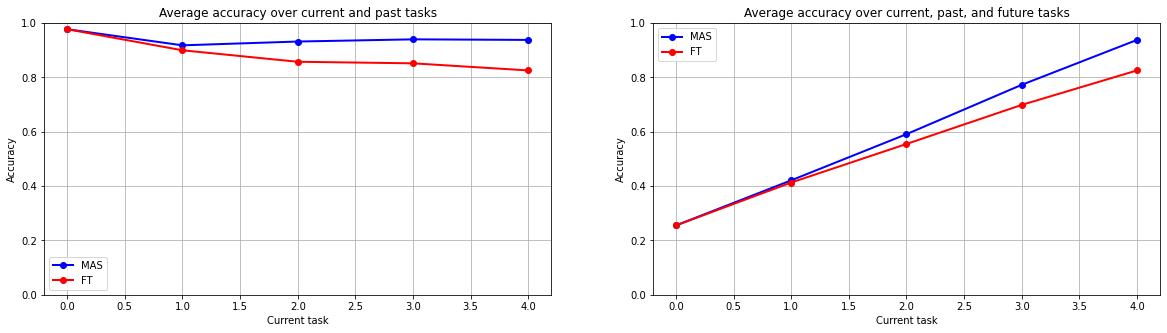

In [23]:
# Compare the results

# Line plots for average accuracy

fig, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].plot(avg_acc_curr_past, lw=2, color='blue', marker='o', label='MAS')
ax[0].plot(avg_acc_curr_past_no_cl, lw=2, color='red', marker='o', label='FT')

ax[1].plot(avg_acc_all, lw=2, color='blue', marker='o', label='MAS')
ax[1].plot(avg_acc_all_no_cl, lw=2, color='red', marker='o', label='FT')

ax[0].set_title("Average accuracy over current and past tasks")
ax[1].set_title("Average accuracy over current, past, and future tasks")
for a in ax:
    a.set_xlabel("Current task")
    a.set_ylabel("Accuracy")
    a.set_ylim([0.0,1.0])
    a.grid(True)
    a.legend()

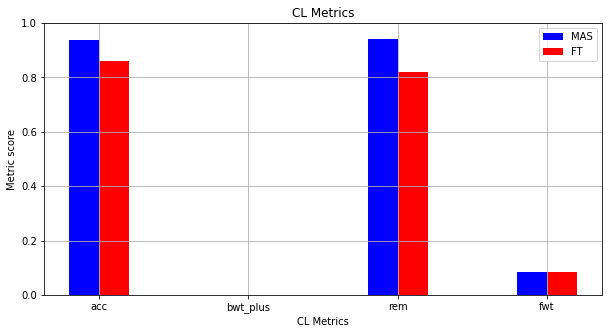

In [24]:
# Bar plots for CL metrics

fig, ax = plt.subplots(1,1,figsize=(10,5))
width = 0.2

ax.bar(np.arange(4)-width/2.0, 
      (cl_metrics['acc'], cl_metrics['bwt_plus'], cl_metrics['rem'], cl_metrics['fwt']), 
       width=width, 
       label='MAS',
       color='blue')
ax.bar(np.arange(4)+width/2.0, 
      (cl_metrics_no_cl['acc'], cl_metrics_no_cl['bwt_plus'], cl_metrics_no_cl['rem'], cl_metrics_no_cl['fwt']), 
       width=width, 
       label='FT',
       color='red')

ax.grid(True)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['acc', 'bwt_plus', 'rem', 'fwt'])
ax.set_xlabel('CL Metrics')
ax.set_ylabel('Metric score')
ax.set_ylim([0.0, 1.0])
ax.legend()
_ = ax.set_title('CL Metrics')